In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from curvemetrics.datafetcher import DataFetcher
from curvemetrics.metricsprocessor import MetricsProcessor
import timeit
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
from web3 import Web3
import matplotlib.pyplot as plt
from curvemetrics.datahandler import DataHandler
import json
from curvemetrics.queries import queries
import ccxt
from datetime import datetime, timedelta
from dotenv import load_dotenv
import os

In [3]:
datahandler = DataHandler()
token_metadata = datahandler.get_token_metadata()
pool_metadata = datahandler.get_pool_metadata()
metricsprocessor = MetricsProcessor(pool_metadata, token_metadata)

In [26]:
pool = "0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7" # 3pool
start = datetime.timestamp(datetime(2023, 3, 1))
end = datetime.timestamp(datetime(2023, 3, 15))

swaps_data = datahandler.get_swaps_data(pool, start, end)
lp_data = datahandler.get_lp_data(pool, start, end)
pool_data = datahandler.get_pool_data(pool, start, end)

tokens = set(swaps_data['tokenBought'])
ohlcvs = {}
ignore = ['0x6c3f90f043a72fa612cbac8115ee7e52bde6e490'] # metapool, ignore LP token for now
for token in tokens:
    if token in ignore:
        continue
    ohlcvs[token] = datahandler.get_ohlcv_data(token, start, end)

In [27]:
def round_date(x):
    mydate = datetime.fromtimestamp(x)
    rounded_minute = mydate.minute + round(mydate.second/60)
    minute_difference = rounded_minute - mydate.minute
    mydate = mydate.replace(second=0) + timedelta(minutes=minute_difference)
    return mydate

def markout(df, ohlcvs, window=timedelta(days=1)):
    df['executionPrice'] = df['amountBought'] / df['amountSold']
    df['roundedDate'] = df['timestamp'].apply(round_date)
    last = df['roundedDate'].iloc[-1]
    df = df[df['roundedDate'] <= last - window]
    df['markoutBoughtPrice'] = df.apply(lambda x: ohlcvs[x['tokenBought']].loc[x['roundedDate'] + window]['close'], axis=1)
    df['markoutSoldPrice'] = df.apply(lambda x: ohlcvs[x['tokenSold']].loc[x['roundedDate'] + window]['close'], axis=1)
    df['markout'] = df['amountSold'] * (df['executionPrice'] * df['markoutBoughtPrice'] - df['markoutSoldPrice'])
    return df

In [60]:
window = timedelta(days=1)
df = swaps_data.copy()
df = markout(df, ohlcvs, window=window)
df = df.set_index('roundedDate')
df['tokenBought'] = df['tokenBought'].apply(lambda x: token_metadata[x]['symbol'])
df['tokenSold'] = df['tokenSold'].apply(lambda x: token_metadata[x]['symbol'])
df = df[['tokenBought', 'tokenSold', 'amountBought', 'amountSold', 'markout', 'executionPrice', 'markoutBoughtPrice', 'markoutSoldPrice']]
df

2023-03-13 23:53:00


/tmp/ipykernel_228104/3606947016.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['markoutBoughtPrice'] = df.apply(lambda x: ohlcvs[x['tokenBought']].loc[x['roundedDate'] + window]['close'], axis=1)
/tmp/ipykernel_228104/3606947016.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['markoutSoldPrice'] = df.apply(lambda x: ohlcvs[x['tokenSold']].loc[x['roundedDate'] + window]['close'], axis=1)
/tmp/ipykernel_228104/3606947016.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy o

,tokenBought,tokenSold,amountBought,amountSold,markout,executionPrice,markoutBoughtPrice,markoutSoldPrice
roundedDate,,,,,,,,
2023-03-01 00:06:00,DAI,USDC,15088.179688,15090.000000,2.706506,0.999879,1.0001,0.9998
2023-03-01 00:07:00,USDT,USDC,4998.884527,5000.000000,0.884304,0.999777,1.0002,0.9998
2023-03-01 00:14:00,DAI,USDC,29946.385193,29950.000000,-0.620169,0.999879,1.0001,1.0000
2023-03-01 00:24:00,DAI,USDC,4959.400905,4960.000000,-0.103155,0.999879,1.0001,1.0000
2023-03-01 00:24:00,DAI,USDC,24197.075162,24200.000000,-0.505130,0.999879,1.0001,1.0000
...,...,...,...,...,...,...,...,...
2023-03-13 23:41:00,DAI,USDT,95759.302479,95301.385527,56.689507,1.004805,0.9979,1.0021
2023-03-13 23:46:00,USDC,USDT,207234.842709,206257.585320,378.230860,1.004738,0.9991,1.0020
2023-03-13 23:46:00,DAI,USDT,93769.845514,93330.025567,168.767035,1.004713,0.9991,1.0020


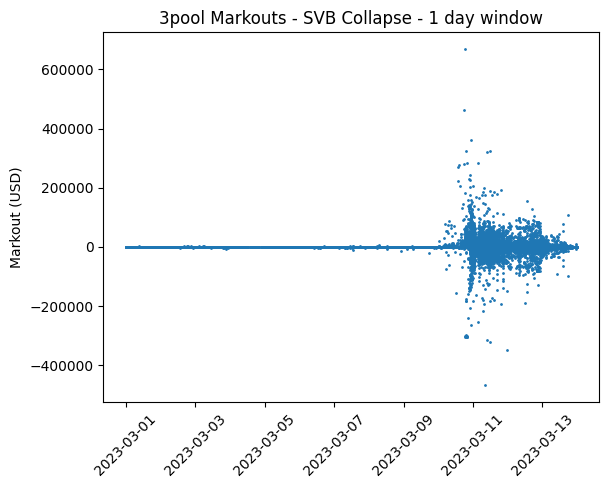

In [61]:
f, ax = plt.subplots()
ax.scatter(df.index, df['markout'], s=1)
ax.set_title(f'3pool Markouts - SVB Collapse - {window.days} day window')
ax.tick_params(axis="x", rotation=45)
ax.set_ylabel('Markout (USD)')
plt.show()

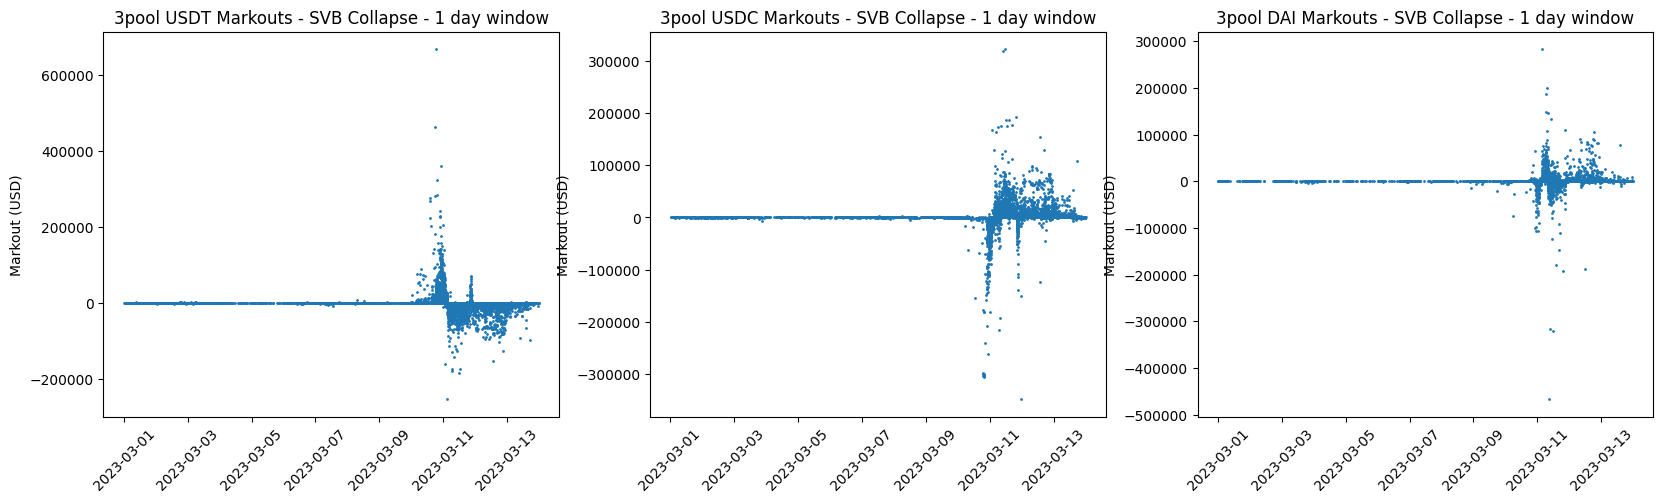

In [62]:
f, axs = plt.subplots(1, len(tokens), figsize=(20, 5))
for i, token in enumerate(tokens):
    symbol = token_metadata[token]['symbol']
    ndf = df[df['tokenBought'] == symbol]
    axs[i].scatter(ndf.index, ndf['markout'], s=1)
    axs[i].set_title(f'3pool {symbol} Markouts - SVB Collapse - {window.days} day window')
    axs[i].tick_params(axis="x", rotation=45)
    axs[i].set_ylabel('Markout (USD)')
plt.show()

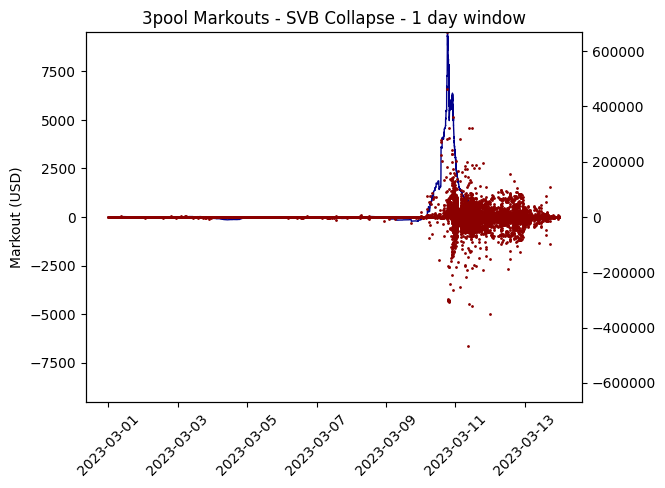

In [80]:
rolling_markouts = df['markout'].rolling('1d').mean()

f, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(rolling_markouts.index, rolling_markouts, c='darkblue', linewidth=1)
ax2.scatter(df.index, df['markout'], s=1, c='darkred')
ax.set_title(f'3pool Markouts - SVB Collapse - {window.days} day window')
ax.tick_params(axis="x", rotation=45)
ax.set_ylabel('Markout (USD)')
axlim = max(abs(rolling_markouts))
ax.set_ylim(-axlim, axlim)
axlim2 = max(abs(df['markout']))
ax2.set_ylim(-axlim2, axlim2)
plt.show()

In [ ]:
rolling_markouts = df['markout'].rolling('1d').mean()

f, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(rolling_markouts.index, rolling_markouts, c='darkblue', linewidth=1)
ax2.scatter(df.index, df['markout'], s=1, c='darkred')
ax.set_title(f'3pool Markouts - SVB Collapse - {window.days} day window')
ax.tick_params(axis="x", rotation=45)
ax.set_ylabel('Markout (USD)')
axlim = max(abs(rolling_markouts))
ax.set_ylim(-axlim, axlim)
axlim2 = max(abs(df['markout']))
ax2.set_ylim(-axlim2, axlim2)
plt.show()